In [4]:
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [154]:
register_df = pd.read_csv("/net/scratch/jmoehring/tiles_register_biome_bin.csv")

In [155]:
register_df[register_df["file_path"].str.contains("13905_8833.tif")]

,base_file_name,file_path,resolution,x,y,label_quality,biome,resolution_bin
317072,uavforsat_2017_CFB036_ortho.tif,/net/scratch/jmoehring/tiles/uavforsat_2017_CF...,0.009,13905,8833,3.0,4.0,0.0


<Axes: >

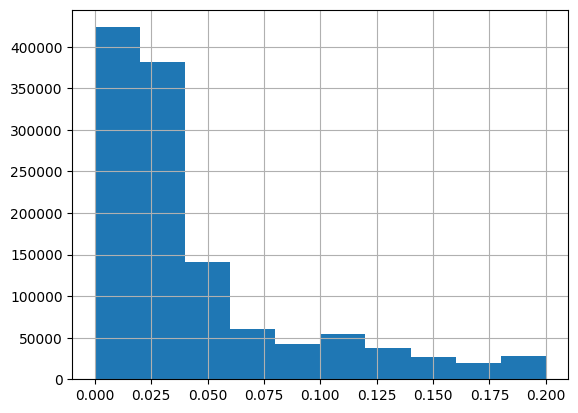

In [8]:
register_df["resolution_bin"].hist()

In [33]:
register_df["resolution_bin_str"].nunique()

11

In [148]:
# Calculate the value counts
value_counts = register_df["resolution_bin"].value_counts()

# Calculate the square root of the counts
sqrt_counts = value_counts.apply(lambda x: x**0.6)

# get the inverse of the square root
class_weights = 1 / sqrt_counts

<Axes: >

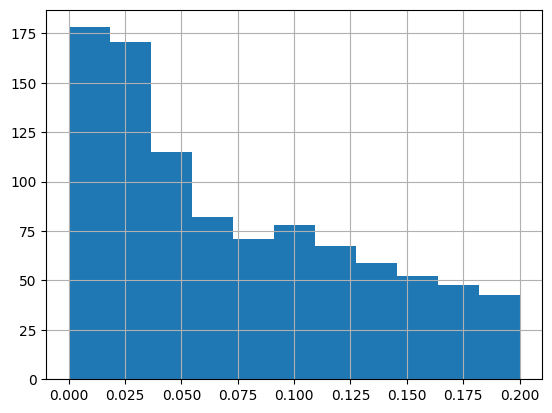

In [149]:
# plot hisogram with value counts multiplied by the class weights
(
    register_df["resolution_bin"].hist(
        weights=register_df["resolution_bin"].map(class_weights), bins=11
    )
)

In [125]:
sample_weights = train_register["resolution_bin"].map(class_weights)

In [122]:
normalized_counts

resolution_bin
0.00    0.028135
0.02    0.029635
0.04    0.048648
0.06    0.074234
0.10    0.078598
0.08    0.089219
0.12    0.094913
0.14    0.112642
0.16    0.129759
0.18    0.146945
0.20    0.167271
Name: count, dtype: float64

<Axes: xlabel='resolution_bin'>

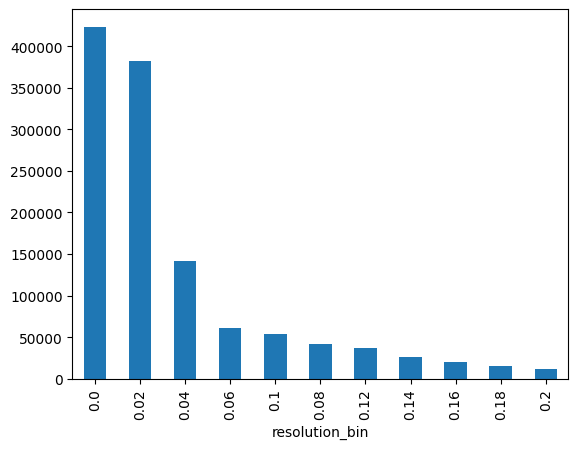

In [55]:
register_df["resolution_bin"].value_counts().plot(kind="bar")

<Axes: xlabel='resolution_bin'>

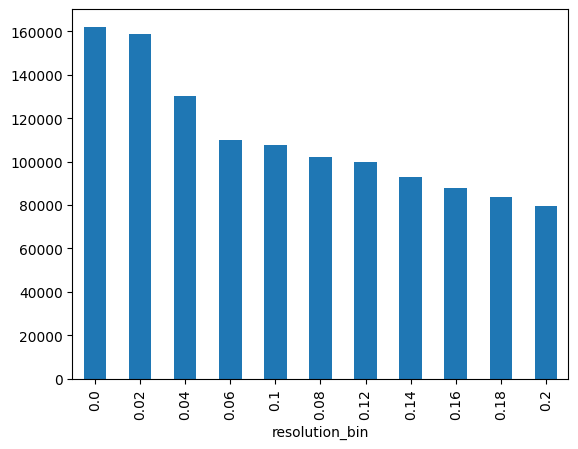

In [56]:
rounded_inverse_counts.plot(kind="bar")

In [104]:
from sklearn.model_selection import StratifiedKFold

base_file_register = (
    register_df.groupby("base_file_name")
    .agg({"resolution_bin": "min", "biome": "first"})
    .reset_index()
)
kfold = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

# get the train and test file register of the first fold
train_index, test_index = list(
    kfold.split(base_file_register, base_file_register[["biome"]].astype(str))
)[0]
train_files = base_file_register.iloc[train_index]
test_files = base_file_register.iloc[test_index]

train_register = register_df[
    register_df["base_file_name"].isin(train_files["base_file_name"])
]
test_register = register_df[
    register_df["base_file_name"].isin(test_files["base_file_name"])
]

/net/home/jmoehring/.conda/envs/standing-deadwood-env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


In [101]:
base_file_register.head()

,base_file_name,resolution_bin,biome
0,20191016_FVA_Walddrohnen_Totholz_8_ortho.tif,0.02,4.0
1,20191024_FVA_Walddrohnen_Totholz_7_ortho.tif,0.02,4.0
2,20200720_FVA_Walddrohnen_Totholz_6_ortho.tif,0.00,4.0
3,20210727_FVA_Walddrohnen_Totholz_5_ortho.tif,0.00,4.0
4,20211001_FVA_Walddrohnen_Totholz_3_ortho.tif,0.02,4.0


<Axes: >

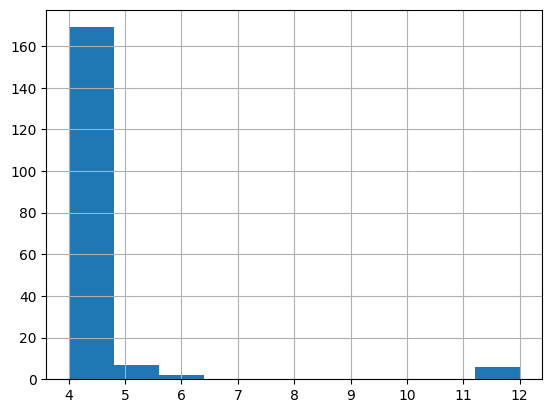

In [102]:
train_files["biome"].hist()

<Axes: >

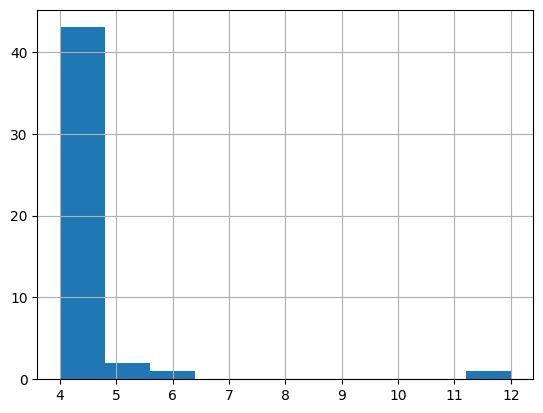

In [103]:
test_files["biome"].hist()